# 00__calculate_cage_exp_and_ts
# calculating CAGE expression and tissue-specificity from FANTOM5 files

in this notebook, i parse FANTOM5 files and calculate CAGE expression & tissue specificities. i use the groups outlined in Supplemental Table S7 to group samples by sample type and omit ambiguous samples, and then calculate average expression across these groups. i also calculate tissue specificity across these groups and assign TSSs to be either "ubiquitous" (expressed in >50% of groups), "dynamic" (expressed in <50% of groups, but expressed at >50tpm in at least 1 group), or "tissue-specific" (expressed in <50% of groups, and never above 50tpm in any group).

i also get a list of 'robust' enhancers using the same criteria defined by fantom5 for the 'robust' TSSs: A ‘robust’ threshold, for which a peak must include a CTSS with more than 10 read counts and 1 TPM (tags per million) at least one sample, was employed to define a stringent subset of the CAGE peaks (from [here](https://www.nature.com/articles/sdata2017112))

------

no figures in this notebook

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time

from os import walk
from scipy.stats import spearmanr

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
all_tss_f = "../../data/00__index/0__all_tss/All.TSS.114bp.bed"

In [4]:
tss_cage_exp_f = "../../misc/01__cage/TSS.CAGE_grouped_exp.tissue_sp.txt.gz"
enh_cage_exp_f = "../../misc/01__cage/Enh.CAGE_grouped_exp.tissue_sp.txt.gz"

In [5]:
robust_enh_f = "../../misc/01__cage/human_robust_enhancers.txt"

## 1. import data

In [6]:
all_tss = pd.read_table(all_tss_f, sep="\t", header=None)
all_tss.columns = ["chr", "start", "end", "name", "score", "strand"]
all_tss.head()

,chr,start,end,name,score,strand
0,chr1,10003350,10003465,"div_pc__p1@LZIC__chr1:10003372..10003465,-",0,-
1,chr1,10003452,10003567,protein_coding__p1@NMNAT1__chr1:10003486..1000...,0,+
2,chr1,100111588,100111703,protein_coding__p1@PALMD__chr1:100111580..1001...,0,+
3,chr1,100232148,100232263,protein_coding__p1@FRRS1__chr1:100232177..1002...,0,-
4,chr1,100315601,100315716,protein_coding__p1@AGL__chr1:100315613..100315...,0,+


In [7]:
tss_cage_exp = pd.read_table(tss_cage_exp_f, sep="\t")
tss_cage_exp.head()

,00Annotation,short_description,Group_0,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,...,Group_542,Group_543,Group_544,Group_545,Group_546,Group_547,Group_548,Group_549,tissue_sp_all,tissue_sp_3
0,"chr10:100013403..100013414,-","p@chr10:100013403..100013414,-",0.54300,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.993829,0.666667
1,"chr10:100027943..100027958,-",p1@LOXL4,27.14998,0.89047,0.0,0.0,0.0,0.1056,0.0,0.101989,...,0.0,0.000000,0.0,0.0,1.603423,2.000139,0.629078,0.0,0.968756,0.666667
2,"chr10:100076685..100076699,+","p@chr10:100076685..100076699,+",0.00000,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.984646,NaN
3,"chr10:100150910..100150935,-","p@chr10:100150910..100150935,-",0.00000,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,...,0.0,0.548168,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.991970,NaN
4,"chr10:100150951..100150962,-","p@chr10:100150951..100150962,-",0.00000,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,...,0.0,1.096335,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.981522,NaN


In [8]:
tss_cage_exp[tss_cage_exp["00Annotation"] == "chr20:49575059..49575077,-"]

,00Annotation,short_description,Group_0,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,...,Group_542,Group_543,Group_544,Group_545,Group_546,Group_547,Group_548,Group_549,tissue_sp_all,tissue_sp_3
102061,"chr20:49575059..49575077,-",p1@DPM1,79.277942,155.386952,78.052286,68.995652,47.83823,100.32032,40.422357,76.797589,...,101.771054,107.577911,114.335837,156.038327,37.680434,85.605942,118.626224,238.480723,0.833704,0.266991


In [9]:
tss_cage_exp["cage_id"] = tss_cage_exp["00Annotation"]
tss_cage_exp.drop(["00Annotation", "short_description"], axis=1, inplace=True)

In [10]:
enh_cage_exp = pd.read_table(enh_cage_exp_f, sep="\t")
enh_cage_exp.head()

,Id,Group_0,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,Group_8,...,Group_542,Group_543,Group_544,Group_545,Group_546,Group_547,Group_548,Group_549,tissue_sp_all,tissue_sp_3
0,chr1:839741-840250,0.0,0.216714,0.0,0.0,0.000000,0.102923,0.000000,0.0,0.0,...,0.0,0.00000,0.306431,0.206949,0.0,0.38338,0.087482,0.110784,0.981674,0.483654
1,chr1:840753-841210,0.0,0.216714,0.0,0.0,0.000000,0.000000,0.543603,0.0,0.0,...,0.0,0.13168,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.984912,0.483654
2,chr1:845485-845678,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.181201,0.0,0.0,...,0.0,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.990033,0.666667
3,chr1:855764-856157,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.990598,0.666667
4,chr1:856539-856757,0.0,0.000000,0.0,0.0,0.199924,0.000000,0.000000,0.0,0.0,...,0.0,0.00000,0.000000,0.000000,0.0,0.00000,0.087482,0.000000,0.977400,0.479531


In [11]:
enh_cage_exp["cage_id"] = enh_cage_exp["Id"]
enh_cage_exp.drop(["Id"], axis=1, inplace=True)

In [12]:
robust_enh = pd.read_table(robust_enh_f, sep="\t", skiprows=1, header=None)
robust_enh.columns = ["cage_id"]
robust_enh.head()

,cage_id
0,chr10:100074404-100074582
1,chr10:100076038-100076149
2,chr10:100076500-100076699
3,chr10:100082942-100083374
4,chr10:100120877-100121283


In [13]:
# limit enhancers to robust only!
enh_cage_exp = enh_cage_exp[enh_cage_exp["cage_id"].isin(robust_enh["cage_id"])]
len(enh_cage_exp)

36906

In [14]:
all_cage_exp = tss_cage_exp.append(enh_cage_exp)
all_cage_exp.sample(5)

,Group_0,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,Group_8,Group_9,...,Group_543,Group_544,Group_545,Group_546,Group_547,Group_548,Group_549,tissue_sp_all,tissue_sp_3,cage_id
67335,0.000000,0.000000,0.000000,0.000000,7.831923,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.994941,NaN,"chr18:45498690..45498695,-"
88758,113.486917,73.352437,131.640423,108.393169,102.873361,286.282512,398.983632,198.164296,250.876699,116.004813,...,171.850574,109.094080,395.968229,114.644725,85.205914,212.448782,185.953435,0.860235,0.286804,"chr1:207925391..207925466,+"
109405,1.628999,0.111309,0.000000,0.399975,1.270041,0.105600,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.327610,0.000000,0.000000,0.000000,0.000000,0.000000,0.954349,0.666667,"chr22:44565901..44565905,+"
100714,0.000000,0.222617,1.164959,0.199987,0.000000,0.000000,0.187141,0.203978,0.210998,0.737319,...,0.000000,1.638049,0.000000,0.000000,0.000000,0.000000,0.000000,0.940528,0.479767,"chr20:42286235..42286249,+"
163621,22.805983,97.395117,0.000000,64.995904,19.473970,39.705727,0.000000,8.669051,57.602472,32.687797,...,5.892803,117.939546,10.514411,24.853052,8.000555,31.543791,124.880493,0.907936,0.535379,"chr6:31324982..31324995,-"


In [15]:
all_cage_exp[all_cage_exp["cage_id"] == "chr20:49575059..49575077,-"]

,Group_0,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,Group_8,Group_9,...,Group_543,Group_544,Group_545,Group_546,Group_547,Group_548,Group_549,tissue_sp_all,tissue_sp_3,cage_id
102061,79.277942,155.386952,78.052286,68.995652,47.83823,100.32032,40.422357,76.797589,89.674177,79.138877,...,107.577911,114.335837,156.038327,37.680434,85.605942,118.626224,238.480723,0.833704,0.266991,"chr20:49575059..49575077,-"


## 2. parse CAGE IDs

In [16]:
def get_cage_id(row):
    if "Enhancer" in row["name"]:
        return row["name"].split("__")[1]
    else:
        return row["name"].split("__")[2]

In [17]:
all_tss["cage_id"] = all_tss.apply(get_cage_id, axis=1)
all_tss.sample(5)

,chr,start,end,name,score,strand,cage_id
13794,chr19,57352059,57352174,"div_pc__p1@PEG3,p1@ZIM2__chr19:57352087..57352...",0,-,"chr19:57352087..57352102,-"
53676,chr8,12728651,12728766,Enhancer__chr8:12728574-12728753,0,+,chr8:12728574-12728753
12686,chr19,21264928,21265043,protein_coding__p1@ZNF714__chr19:21264991..212...,0,+,"chr19:21264991..21265026,+"
48791,chr5,173300218,173300333,Enhancer__chr5:173300199-173300299,0,+,chr5:173300199-173300299
344,chr1,145575206,145575321,protein_coding__p1@PIAS3__chr1:145575227..1455...,0,+,"chr1:145575227..145575319,+"


## 3. get av exp & t.s. across all samples

In [18]:
samples = [x for x in all_cage_exp.columns if "Group_" in x]
all_cage_exp["av_exp"] = all_cage_exp[samples].mean(axis=1)
all_cage_exp.sample(5)

,Group_0,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,Group_8,Group_9,...,Group_544,Group_545,Group_546,Group_547,Group_548,Group_549,tissue_sp_all,tissue_sp_3,cage_id,av_exp
7780,0.000000,0.000000,0.0,0.000000,0.399847,0.000000,0.000000,0.000000,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.989994,NaN,chr10:73486376-73486761,0.014971
4575,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.993770,NaN,chr1:201711711-201712036,0.055753
19033,0.000000,0.222617,0.0,0.000000,0.000000,0.316801,0.561422,0.101989,0.000000,0.0,...,0.00000,0.000000,2.405134,0.0,0.718947,0.000000,0.958140,0.666667,"chr11:830411..830427,+",0.154281
9948,1.085999,0.000000,0.0,0.199987,0.000000,0.105600,0.000000,0.407955,0.210998,0.0,...,0.32761,0.335566,0.000000,0.0,0.269605,0.341826,0.956515,0.512201,"chr11:114320753..114320762,+",0.193618
35116,0.000000,0.000000,0.0,0.399975,0.000000,0.000000,0.187141,0.000000,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.089868,0.000000,0.956943,0.565997,"chr14:101053739..101053767,-",0.273784


## 4. merge

In [19]:
all_tss[all_tss["cage_id"] == "chr20:49575059..49575077,-"]

,chr,start,end,name,score,strand,cage_id


In [20]:
all_tss = all_tss.merge(all_cage_exp[["cage_id", "av_exp", "tissue_sp_all"]], on="cage_id")
all_tss.sample(5)

,chr,start,end,name,score,strand,cage_id,av_exp,tissue_sp_all
20037,chr10,4713077,4713192,Enhancer__chr10:4712833-4713220,0,+,chr10:4712833-4713220,0.052100,0.982400
31502,chr6,111255370,111255485,Enhancer__chr6:111255245-111255563,0,+,chr6:111255245-111255563,0.013840,0.995588
962,chr1,215740637,215740752,protein_coding__p1@KCTD3__chr1:215740709..2157...,0,+,"chr1:215740709..215740748,+",15.087424,0.862439
3885,chr12,2027776,2027891,"div_pc__p2@CACNA2D4__chr12:2027805..2027827,-",0,-,"chr12:2027805..2027827,-",1.596958,0.996628
1460,chr1,45272922,45273037,protein_coding__p2@TCTEX1D4__chr1:45272951..45...,0,-,"chr1:45272951..45272962,-",0.042662,0.992429


## 5. define promtype2

In [21]:
all_tss["PromType2"] = all_tss["name"].str.split("__", expand=True)[0]
all_tss.sample(5)

,chr,start,end,name,score,strand,cage_id,av_exp,tissue_sp_all,PromType2
10005,chr2,28648489,28648604,"intergenic__p@chr2:28648566..28648572,+__chr2:...",0,+,"chr2:28648566..28648572,+",0.037784,0.993266,intergenic
35543,chrX,43865580,43865695,Enhancer__chrX:43865290-43865713,0,+,chrX:43865290-43865713,0.003751,0.994209,Enhancer
25621,chr19,54463678,54463793,Enhancer__chr19:54463562-54463897,0,+,chr19:54463562-54463897,0.220078,0.988470,Enhancer
23065,chr14,89467112,89467227,Enhancer__chr14:89466992-89467193,0,+,chr14:89466992-89467193,0.058380,0.987692,Enhancer
5769,chr15,74753442,74753557,"div_pc__p1@UBL7__chr15:74753455..74753533,-",0,-,"chr15:74753455..74753533,-",30.729673,0.856152,div_pc


In [22]:
all_tss.PromType2.unique()

array(['div_pc', 'protein_coding', 'div_lnc', 'antisense', 'intergenic',
       'Enhancer'], dtype=object)

## 5. plot

In [23]:
all_tss["log_av_exp"] = np.log(all_tss["av_exp"]+1)

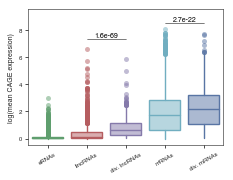

In [24]:
fig = plt.figure(figsize=(3.5, 2.5))
ax = sns.boxplot(data=all_tss, x="PromType2", y="log_av_exp", 
                 flierprops = dict(marker='o', markersize=5), order=TSS_CLASS_ORDER, palette=TSS_CLASS_PALETTE)
ax.set_xticklabels(["eRNAs", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"], rotation=30)
mimic_r_boxplot(ax)


# calc p-vals b/w divergent and non
lincs = np.asarray(all_tss[all_tss["PromType2"] == "intergenic"]["log_av_exp"])
div_lncs = np.asarray(all_tss[all_tss["PromType2"] == "div_lnc"]["log_av_exp"])
pcs = np.asarray(all_tss[all_tss["PromType2"] == "protein_coding"]["log_av_exp"])
div_pcs = np.asarray(all_tss[all_tss["PromType2"] == "div_pc"]["log_av_exp"])

lincs = lincs[~np.isnan(lincs)]
div_lncs = div_lncs[~np.isnan(div_lncs)]
pcs = pcs[~np.isnan(pcs)]
div_pcs = div_pcs[~np.isnan(div_pcs)]

lnc_u, lnc_pval = stats.mannwhitneyu(lincs, div_lncs, alternative="two-sided", use_continuity=False)
pc_u, pc_pval = stats.mannwhitneyu(pcs, div_pcs, alternative="two-sided", use_continuity=False)

annotate_pval(ax, 1, 2, 7.3, 0, 0, lnc_pval, fontsize, False, None, None)
annotate_pval(ax, 3, 4, 8.5, 0, 0, pc_pval, fontsize, False, None, None)

plt.ylim((-0.5, 9.5))
plt.xlabel("")
plt.ylabel("log(mean CAGE expression)")
fig.savefig("cage_exp_all_proms.pdf", dpi="figure", bbox_inches="tight")

In [25]:
print("lnc pval: %s" % lnc_pval)
print("pc pval: %s" % pc_pval)

lnc pval: 1.57929015786e-69
pc pval: 2.66992847149e-22


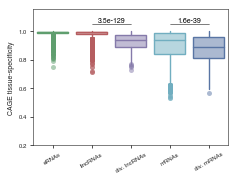

In [27]:
fig = plt.figure(figsize=(3.5, 2.5))
ax = sns.boxplot(data=all_tss, x="PromType2", y="tissue_sp_all", 
                 flierprops = dict(marker='o', markersize=5), order=TSS_CLASS_ORDER, palette=TSS_CLASS_PALETTE)
ax.set_xticklabels(["eRNAs", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"], rotation=30)
mimic_r_boxplot(ax)


# calc p-vals b/w divergent and non
lincs = np.asarray(all_tss[all_tss["PromType2"] == "intergenic"]["tissue_sp_all"])
div_lncs = np.asarray(all_tss[all_tss["PromType2"] == "div_lnc"]["tissue_sp_all"])
pcs = np.asarray(all_tss[all_tss["PromType2"] == "protein_coding"]["tissue_sp_all"])
div_pcs = np.asarray(all_tss[all_tss["PromType2"] == "div_pc"]["tissue_sp_all"])

lincs = lincs[~np.isnan(lincs)]
div_lncs = div_lncs[~np.isnan(div_lncs)]
pcs = pcs[~np.isnan(pcs)]
div_pcs = div_pcs[~np.isnan(div_pcs)]

lnc_u, lnc_pval = stats.mannwhitneyu(lincs, div_lncs, alternative="two-sided", use_continuity=False)
pc_u, pc_pval = stats.mannwhitneyu(pcs, div_pcs, alternative="two-sided", use_continuity=False)
    
annotate_pval(ax, 1, 2, 1.05, 0, 0, lnc_pval, fontsize, False, None, None)
annotate_pval(ax, 3, 4, 1.05, 0, 0, pc_pval, fontsize, False, None, None)

plt.ylim((0.2, 1.15))
plt.xlabel("")
plt.ylabel("CAGE tissue-specificity")
fig.savefig("cage_ts_all_proms.pdf", dpi="figure", bbox_inches="tight")

In [28]:
print("lnc pval: %s" % lnc_pval)
print("pc pval: %s" % pc_pval)

lnc pval: 3.52167111424e-129
pc pval: 1.60610483516e-39


## define promoters as "ubiquitous" v "tissue-specific"
ubiquitous = on in >50% of samples
dynamic = on in < 50% of samples, in at least 1 sample on at > 10
tissue-sp = on in < 50% of samples

In [29]:
all_cage_exp["n_expr"] = all_cage_exp[samples].astype(bool).sum(axis=1)
all_cage_exp.head()

,Group_0,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,Group_8,Group_9,...,Group_545,Group_546,Group_547,Group_548,Group_549,tissue_sp_all,tissue_sp_3,cage_id,av_exp,n_expr
0,0.54300,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.993829,0.666667,"chr10:100013403..100013414,-",0.023403,38
1,27.14998,0.89047,0.0,0.0,0.0,0.1056,0.0,0.101989,0.000000,0.0,...,0.0,1.603423,2.000139,0.629078,0.0,0.968756,0.666667,"chr10:100027943..100027958,-",5.375834,346
2,0.00000,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.210998,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.984646,NaN,"chr10:100076685..100076699,+",0.012479,34
3,0.00000,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.991970,NaN,"chr10:100150910..100150935,-",0.155925,80
4,0.00000,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.981522,NaN,"chr10:100150951..100150962,-",0.038083,49


In [30]:
len(all_cage_exp)

238369

In [31]:
def expr_type(row, samples, thresh):
    if row.n_expr > 0.9*len(samples):
        return "ubiquitous"
    elif row.n_expr < 0.1*len(samples):
        exprs = list(row[samples])
        over_thresh = any(i >= thresh for i in exprs)
        if over_thresh > 0:
            return "dynamic"
        else:
            return "tissue-specific"
    else:
        return "moderate"

all_cage_exp["tss_type"] = all_cage_exp.apply(expr_type, axis=1, samples=samples, thresh=50)
all_cage_exp.sample(10)

,Group_0,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,Group_8,Group_9,...,Group_546,Group_547,Group_548,Group_549,tissue_sp_all,tissue_sp_3,cage_id,av_exp,n_expr,tss_type
155081,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.997905,NaN,"chr5:6829869..6829889,+",0.007720,7,tissue-specific
7783,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.995489,NaN,"chr10:90251152..90251159,-",0.020589,6,tissue-specific
143689,0.543,0.667852,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,8.847825,...,0.000000,1.600111,0.269605,1.367305,0.977309,NaN,"chr4:41540197..41540212,+",0.845424,214,moderate
39493,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.972276,NaN,"chr14:65213607..65213610,-",0.450160,130,moderate
49944,0.000,0.222617,1.164959,0.199987,0.211674,0.316801,0.0,0.407955,0.000000,0.000000,...,0.801711,0.000000,0.539210,0.113942,0.963061,0.244596,"chr16:24842180..24842181,+",0.163776,253,moderate
189890,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.982716,NaN,"chr9:131683298..131683313,+",0.107748,76,moderate
62998,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.196291,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.991595,NaN,chr9:114775716-114775991,0.019333,33,tissue-specific
149991,0.543,0.111309,0.000000,0.199987,0.000000,0.000000,0.0,1.631821,0.210998,0.245773,...,1.603423,0.000000,0.000000,0.341826,0.980216,NaN,"chr5:146833322..146833339,-",1.363507,316,moderate
177588,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.969811,NaN,"chr7:86273700..86273716,+",0.213016,56,moderate
24182,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.997879,NaN,"chr12:26126668..26126674,+",0.030833,11,tissue-specific


In [32]:
all_cage_exp.tss_type.value_counts()

moderate           130287
tissue-specific     83651
ubiquitous          20304
dynamic              4127
Name: tss_type, dtype: int64

## write file

In [33]:
final = all_cage_exp[["cage_id", "av_exp", "tissue_sp_all",  "tissue_sp_3", "n_expr", "tss_type"]]
final.sample(5)

,cage_id,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
149631,"chr5:14202798..14202821,+",0.760060,0.970539,NaN,216,moderate
15686,"chr11:61615643..61615659,+",0.209187,0.974591,0.548442,242,moderate
1639,"chr10:120530382..120530392,-",0.018430,0.997790,NaN,6,tissue-specific
143262,"chr4:3486494..3486515,-",0.107262,0.986629,0.666667,81,moderate
3582,chr1:160376163-160376541,0.049814,0.992781,NaN,74,moderate


In [34]:
final[final["tss_type"] == "dynamic"].sample(5)

,cage_id,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
18346,"chr11:73720122..73720136,-",0.980521,0.995529,NaN,35,dynamic
98708,"chr20:19896173..19896228,-",0.377229,0.997424,NaN,35,dynamic
192017,"chr9:226208..226216,-",0.261290,0.998102,0.666667,7,dynamic
170595,"chr7:130023610..130023622,-",0.160638,0.998042,NaN,5,dynamic
100969,"chr20:43837283..43837290,+",0.160902,0.997697,NaN,3,dynamic


In [35]:
# chr16:2918256-2918257
final[final["cage_id"].str.contains("chr16:2918")]

,cage_id,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
50441,"chr16:2918192..2918219,-",0.374625,0.879067,0.477934,408,moderate
22322,chr16:29189422-29189633,0.016184,0.989682,NaN,29,tissue-specific


In [36]:
final.to_csv("../../misc/01__cage/All_TSS_and_enh.CAGE_grouped_exp.tissue_sp.txt", sep="\t", index=False)

In [37]:
len(final)

238369